<a href="https://colab.research.google.com/github/BaharehYekkehkhany/SAR-Vegetation-Index/blob/main/RS2_RapidEye_NDVI_220222_noSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## panda: load and store dataframe structures (tabular data)
import pandas as pd
## numpy: a numerical python library; to work with multi-dimentional arrays and mtrices
import numpy as np
## matplotlib: 2D and 3D plotting
import matplotlib.pyplot as plt
## sklearn: machine learning methods
## sklearn.linear_model.LinearRegression: provides linear regression function
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.metrics import explained_variance_score, max_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
## Msklearn.neural_network.MLPRegressor: multi-layer Perceptron regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
# from sklearn import metrics
# import seaborn as sns
# # SVM classifier
# from sklearn.svm import SVC
# # to prepare data for SVM classification
# from sklearn.datasets.samples_generator import make_blobs
# from sklearn.datasets.samples_generator import make_circles
# from mpl_toolkits.mplot3d import Axes3D
## to load .mat files
from scipy.io import loadmat
from numpy import arange
import cmath
# ## to use HDF reader for matlab v7.3 files
# import h5py
import scipy
import scipy.io as spio

## https://www.youtube.com/watch?v=maiQf8ray_s
from scipy.stats import zscore
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation


##------------------------------------------------------------------------------
## change directory to google drive to read input and output data
##------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')


##------------------------------------------------------------------------------
## import data
##------------------------------------------------------------------------------
## This function is a modified version of scipy.io.loadmat to read nested structures saved as .mat
## MATLAB reference: https://ch.mathworks.com/matlabcentral/answers/383427-proper-importing-of-matlab-structures-into-python
## Stack Overflow reference: https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def load_mat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

##------------------------------------------------------------------------------
def import_data():

  """
  import dataset: read 3 structures that include RS2 and RapidEye observations

  inputs:
  3 structures that contains some RS2 parameters as well as NDVI obtained from
  RapidEye observations for 3 years (2012 - 10 days, 2016 - 23 days, and
  2019 - 14 days).

  The structures include field_ID, RS2_acquisition_date,
  RS2_Acquisition_day_number (day number of year), RapidEye_acquisition_date,
  and RapidEye_Acquisition_day_number (day number of year).
  Date values are used to interpolate NDVI values and to assign one value of
  NDVI to each RS2 observation based on the closest acquisition time.

  All parameters extracted from RS2 data will be predictor variables and the
  correspondence NDVI values are the desired outcomes to be estimated.

  outputs:
  dataset: a dictionary that includes all structure variables
  """

  ## 2012
  dataset_2012 = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/RS2_2012_QP_NDVI_scale2_field_10days_.mat')['RS2_2012_QP_NDVI_scale2_field_10days']
  # dataset_2012 = dataset_2012['RS2_2012_QP_NDVI_scale2_field_10days']

  ## add volume to surface scattering ratio to parameters
  ## volume to surface scattering ratio is based on Saied Homayouni, Heather McNairn, and Xianfeng Jiao's paper
  dataset_2012['volume_to_surface_scattering_Canola'] = (np.array(dataset_2012['Freeman_Volume_Canola']) - np.array(dataset_2012['Freeman_Surface_Canola'])).tolist()
  ## add radar vegetation index (RVI) to parameters
  ## RVI is based on "https://trs.jpl.nasa.gov/bitstream/handle/2014/14473/00-0913.pdf?sequence=1"
  dataset_2012['radar_vegetation_index'] = (8*np.array(dataset_2012['Backscatter_HV_Canola'])/ (np.array(dataset_2012['Backscatter_HH_Canola']) + np.array(dataset_2012['Backscatter_VV_Canola']) + 2*np.array(dataset_2012['Backscatter_HV_Canola']))).tolist()
  dataset_2012.pop('Index_RVI_Canola')

  # print('dataset_2012.keys:')
  # print(dataset_2012.keys())

  ## 2016
  dataset_2016 = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/RS2_2016_QP_scale10_Fields_Canola_23days_.mat')['RS2_2016_QP_scale10_Fields_Canola_23days']
  # dataset_2016 = dataset_2016['RS2_2016_QP_scale10_Fields_Canola_23days']

  ## add volume to surface scattering ratio to parameters
  dataset_2016['volume_to_surface_scattering_Canola'] = (np.array(dataset_2016['Freeman_Volume_Canola']) - np.array(dataset_2016['Freeman_Surface_Canola'])).tolist()
  ## add radar vegetation index (RVI) to parameters
  ## RVI is based on "https://trs.jpl.nasa.gov/bitstream/handle/2014/14473/00-0913.pdf?sequence=1"
  dataset_2016['radar_vegetation_index'] = (8*np.array(dataset_2016['Backscatter_HV_Canola'])/ (np.array(dataset_2016['Backscatter_HH_Canola']) + np.array(dataset_2016['Backscatter_VV_Canola']) + 2*np.array(dataset_2016['Backscatter_HV_Canola']))).tolist()
  ## change the name of some of the keys to make them consistent with other dataset
  dataset_2016['NDVI_Canola_Field'] = dataset_2016.pop('NDVI_Canola_Fields')
  dataset_2016['Anisotropy_Canola'] = dataset_2016.pop('Ansiotropy_Canola')
  dataset_2016['Span_Canola'] = dataset_2016.pop('SpanCanola')
  dataset_2016.pop('Backscatter_VH_Canola')
  dataset_2016.pop('Index_RVI_Canola')

  # print('dataset_2016.keys:')
  # print(dataset_2016.keys())

  ## 2019
  dataset_2019 = load_mat('/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/RS2_2019_QP_scale10_Fields_Canola_14days_.mat')['RS2_2019_QP_scale10_Fields_Canola_14days']
  # dataset_2019 = dataset_2019['RS2_2019_QP_scale10_Fields_Canola_14days']

  ## add volume to surface scattering ratio to parameters
  dataset_2019['volume_to_surface_scattering_Canola'] = (np.array(dataset_2019['Freeman_Volume_Canola']) - np.array(dataset_2019['Freeman_Surface_Canola'])).tolist()
  ## add radar vegetation index (RVI) to parameters
  ## RVI is based on "https://trs.jpl.nasa.gov/bitstream/handle/2014/14473/00-0913.pdf?sequence=1"
  dataset_2019['radar_vegetation_index'] = (8*np.array(dataset_2019['Backscatter_HV_Canola'])/ (np.array(dataset_2019['Backscatter_HH_Canola']) + np.array(dataset_2019['Backscatter_VV_Canola']) + 2*np.array(dataset_2019['Backscatter_HV_Canola']))).tolist()
  ## change the name of some of the keys to make them consistent with other dataset
  dataset_2019['PedestalHeight_Canola'] = dataset_2019.pop('PedestaHeight_Canola')
  dataset_2019['Anisotropy_Canola'] = dataset_2019.pop('Ansiotropy_Canola')
  dataset_2019.pop('Index_RVI_Canola')


  # print('dataset_2019.keys:')
  # print(dataset_2019.keys())

  ## convert dictionary to dataframe
  # dataset_2012 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dataset_2012.items() ]))

  ## replace +/- inf values with nan
  # dataset_2012.replace([np.inf, -np.inf], np.nan, inplace=True)
  # print(inputs.isna().sum())
  ## replace nan values with 0
  # dataset_2012.fillna(0, inplace=True)

  return dataset_2012, dataset_2016, dataset_2019


##------------------------------------------------------------------------------
## prepare input and output for regression
##------------------------------------------------------------------------------
def input_output_preparation(dataset_2012, dataset_2016, dataset_2019, scaling, scaling_method):

  """
  Vectorize the datasets and separate them into input and output dataframes for
  the NDVI estimation process

  input:
  dataset: a dictionary that includes all variables

  output:
  inputs_vectored: a dataframe that includes all predictor variables
  outputs_vectored: a dataframe that includes all correspondence intepolated NDVI values
  """
  datasets = [dataset_2012, dataset_2016, dataset_2019]
  i = 0
  years = [2012, 2016, 2019]
  input_yearly = {}
  output_yearly = {}
  input_with_invalid_NDVIs_yearly = {}
  output_with_invalid_NDVIs_yearly = {}
  samples = {}
  samples['information'] = ['n_fields', 'n_days', 'n_samples']
  for dataset in datasets:

    year = str(years[i])
    i = i + 1

    input = dataset.copy()

    ## remove keys that are not needed in the regression process
    [input.pop(x, None) for x in ['Field_ID_Canola', 'NDVI_Canola_Field']]
    input = pd.DataFrame.from_dict(input)

    ## vectorize dataset
    ## first, find the number of fields (n_fields), number of days (n_days)
    ## so the number of samples = n_fields*n_days
    n_fields, n_days = np.shape(dataset['NDVI_interpolated'])
    samples[year] = [n_fields, n_days, n_fields*n_days]

    input_vector = []
    input_vectored = pd.DataFrame()
    for key in input.keys():
      input_vector = []
      for field in range(n_fields):
        for day in range(n_days):
          input_vector.append(input[key][field][day])
      temp = pd.DataFrame(input_vector, columns=[key], dtype='float64')
      temp.reset_index(drop=True, inplace=True)
      input_vectored = pd.concat([input_vectored , temp], axis=1)

    data_vectored_with_invalid_NDVIs = input_vectored.copy()
    ## remove NaN values
    input_vectored.dropna(axis=0, how='any', inplace=True)
    ## remove rows with NDVI_interpolated = 0
    input_vectored = input_vectored[input_vectored.NDVI_interpolated != 0]
    ## remove rows with NDVI_interpolated < 0 (remove negative NDVI values)
    input_vectored = input_vectored[input_vectored.NDVI_interpolated > 0]
    ## remove rows with NDVI_interpolated > 100 (NDVI range here is between 0 and 100)
    input_vectored = input_vectored[input_vectored.NDVI_interpolated < 100]

    ## separate input and output dataframe
    output_vectored = pd.DataFrame({'NDVI_interpolated': \
                                    input_vectored['NDVI_interpolated']})
    input_vectored.drop(['NDVI_interpolated'], axis=1, inplace=True)

    ## generate input and output with invalid NDVI values
    ## these are created so that at the end, all samples can be sorted based on
    ## their field number and day number
    output_vectored_with_invalid_NDVIs = pd.DataFrame({'NDVI_interpolated': \
                        data_vectored_with_invalid_NDVIs['NDVI_interpolated']})
    data_vectored_with_invalid_NDVIs.drop(['NDVI_interpolated'], axis=1, \
                                          inplace=True)
    input_vectored_with_invalid_NDVIs = data_vectored_with_invalid_NDVIs.copy()


    ## normalize input and output data
    if scaling == 1:
      if scaling_method == 'min_max':
        ## min-max normalization:
        input_year = (input_vectored - input_vectored.min())/( \
                      input_vectored.max() - input_vectored.min())
        input_vectored_with_invalid_NDVIs = \
          (input_vectored_with_invalid_NDVIs - input_vectored_with_invalid_NDVIs.min())/( \
            input_vectored_with_invalid_NDVIs.max() - input_vectored_with_invalid_NDVIs.min())
      elif scaling_method == 'mean_std':
        ## mean_std standardization
        input_year = (input_vectored - input_vectored.mean())/input_vectored.std()
        input_vectored_with_invalid_NDVIs = (input_vectored_with_invalid_NDVIs - \
          input_vectored_with_invalid_NDVIs.mean())/input_vectored_with_invalid_NDVIs.std()
    else:
      input_year = input_vectored.copy()

    output_year = output_vectored.copy()

    input_yearly[year] = input_year.copy()
    output_yearly[year] = output_year.copy()

    input_with_invalid_NDVIs_yearly[year] = \
      input_vectored_with_invalid_NDVIs.copy()
    output_with_invalid_NDVIs_yearly[year] = \
      output_vectored_with_invalid_NDVIs.copy()

  return input_yearly, output_yearly, input_with_invalid_NDVIs_yearly, \
    output_with_invalid_NDVIs_yearly, samples


##------------------------------------------------------------------------------
## predictor variable selection
##------------------------------------------------------------------------------
def predictor_selection(inputs, outputs, input_vectored_with_invalid_NDVIs, \
                        alpha, selection_criteria, model_name):

  if model_name.lower() in ['lasso']:
    ## Lasso(alpha=1.0, *, fit_intercept=True, normalize=True,\
    ##  precompute=False, copy_X=True, max_iter=1000, tol=0.0001, \
    ##  warm_start=False, positive=False, random_state=None, selection='cyclic')
    model = Lasso(alpha=alpha)
    model.fit(inputs.values, outputs)
  elif model_name.lower() in ['ridge']:
    ## Ridge(alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, \
    ##  max_iter=None, tol=0.001, solver='auto', random_state=None)
    model = Ridge(alpha=alpha)
    model.fit(inputs.values, outputs)

  selected_columns = abs(model.coef_) > selection_criteria
  if np.any(selected_columns):
    selected_inputs = inputs.loc[:, np.transpose(selected_columns)]
    selected_input_vectored_with_invalid_NDVIs = \
        input_vectored_with_invalid_NDVIs.loc[:, np.transpose(selected_columns)]
  else:
    selected_columns = abs(model.coef_) == max(abs(model.coef_))
    selected_inputs = inputs.loc[:, selected_columns]
    selected_input_vectored_with_invalid_NDVIs = \
        input_vectored_with_invalid_NDVIs.loc[:, selected_columns]
  print('\nselected input features')
  print(selected_inputs.keys())
  print('\n input coefficients after feature selection:')
  print(model.coef_)

  # model = Lasso(alpha=alpha)
  # # model.fit(inputs.iloc[0,:].values, outputs.iloc[0,:].values)
  # # model.fit(inputs.values, outputs.values)
  # model.fit(inputs.values.real, outputs)
  # selected_columns = model.coef_ > selection_criteria
  # selected_inputs = inputs.loc[:, selected_columns]
  # print('selected_inputs.keys')
  # print(selected_inputs.keys())
  # print(model.coef_)

  return selected_inputs, selected_input_vectored_with_invalid_NDVIs, selected_columns


##------------------------------------------------------------------------------
## regression models
##------------------------------------------------------------------------------

##------------------------------------------------------------------------------
## MLP regression
def mlp_regression(input, output, selected_input_vectored_with_invalid_NDVIs, \
                   activation, solver, alpha, batch_size, max_iter, k_fold):

## neural network multi-layer Perceptron (NN-MLP) regressor
## This model optimizes the squared-loss using LBFGS or stochastic gradient descent.
## evaluate the model predictions using the test data

## input:
## x_train, y_train: train data
## x_test, y_test: test data
## max_iter: maximum iteration of the MLP regressor

## output:
  # model = MLPRegressor(max_iter, batch_size=min(batch_size, x_train.shape[0]), \
  #                       random_state=1)

  x = input.values
  y = output.values

  ## cross validation iterators
  ## K-fold
  from sklearn.model_selection import KFold
  kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
  cvi = kf
  ## repeated K-fold
  # from sklearn.model_selection import RepeatedKFold
  # rkf = RepeatedKFold(n_splits=k_fold, n_repeats=3, random_state=42)
  # cvi = rkf
  ## leave one out
  # from sklearn.model_selection import LeaveOneOut
  # loo = LeaveOneOut()
  # cvi = loo
  ## leave P out
  # from sklearn.model_selection import LeavePOut
  # lpo = LeavePOut(p=2)
  # cvi = lpo
  # ## Random permutations cross-validation a.k.a. Shuffle & Split
  # from sklearn.model_selection import ShuffleSplit
  # ss = ShuffleSplit(n_splits=k_fold, test_size=0.2, random_state=1)
  # cvi = ss


  oos_y = []
  oos_pred = []

  rmse = 1
  fold = 0
  for train, test in cvi.split(x):
    fold+=1
    print(f"Fold #{fold}")

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation=activation))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=solver)

    # model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=max_iter)
    model.fit(x_train, y_train, validation_split=0.2, verbose=0, epochs=100)

    pred = model.predict(x_test)

    ## out of sample: oos
    oos_y.append(y_test)
    oos_pred.append(pred)

    ## measure this fold's rmse
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"Fold rmse: {score:5.3f}")
    print(f"Fold mean absolute error: {mean_absolute_error(y_test, pred):5.3f}")
    print(f"Fold r2: {r2_score(y_test, pred):5.3f}")
    cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
    print(f"Fold correlation coefficient: {cc[0, 1]:5.3f}")

    out_predict = model.predict(x)
    plt.scatter(out_predict, y, color="blue")
    plt.xlabel("predicted NDVI by neural networks")
    plt.ylabel("interpolated NDVI measured by RapidEye")
    plt.title("neural networks regression")
    plt.show()

    ## find the best model and predict the output (NDVI) for all the input data
    ## with the best model
    if score < rmse:
      rmse = score
      output_predicted_vectored_with_invalid_NDVIs = \
          model.predict(selected_input_vectored_with_invalid_NDVIs)
      output_predict = model.predict(input)
      best_x_train = x_train
      best_y_train = y_train
      best_x_test = x_test
      best_y_test = y_test

      best_model = model

      best_rmse = score
      best_r2 = r2_score(y_test, pred)
      best_cc = cc[0, 1]
      best_mae = mean_absolute_error(y_test, pred)

      best_fold = fold

  ## Show the statistics for the best fold
  print(f"\n \nBest fold number: {best_fold}")
  print(f"Best model rmse: {best_rmse:5.3f}")
  print(f"Best model mae: {best_mae:5.3f}")
  print(f"Best model r2: {best_r2:5.3f}")
  print(f"Best model cc: {best_cc:5.3f}")

  ## plot NDVI interpolated data vs NDVI predicted data
  plt.scatter(output_predict, y, color="blue")
  plt.xlabel("predicted NDVI by NN model")
  plt.ylabel("interpolated NDVI measured by RapidEye")
  plt.title("NN regression")
  plt.show()

  ## polts color-filtered by wind speed values
  ## train and test separated
  print('train size:')
  print(np.shape(best_y_train))
  print('test size:')
  print(np.shape(best_y_test))
  print('\n')
  plt.title('NN regression')
  plt.scatter(best_model.predict(best_x_train), best_y_train, label="train data")
  plt.scatter(best_model.predict(best_x_test), best_y_test, label="test data")
  plt.xlabel("predicted NDVI by NN model")
  plt.ylabel("interpolated NDVI measured by RapidEye")
  plt.legend()
  plt.show()

  ## out of sample (OOS)
  ## build the oos prediction list and calculate error
  oos_y = np.concatenate(oos_y)
  oos_pred = np.concatenate(oos_pred)
  score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
  print(f"\n \nFinal, out of sample rmse: {score:5.3f}")
  print(f"Final, out of sample mae: {mean_absolute_error(oos_y, oos_pred):5.3f}")
  print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred):5.3f}")
  corre_coef = np.corrcoef(np.transpose(oos_pred), \
              np.transpose(oos_y))
  print(f"Final, out of sample cc: {corre_coef[0, 1]:5.3f}")
  # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

  ## convert the out of sample dataset to DataFrame
  oos_y = pd.DataFrame(oos_y)
  oos_pred = pd.DataFrame(oos_pred)
  oosDF = pd.concat([oos_y, oos_pred], axis=1)
  # oosDF.to_csv(filename_write, index=False)

  ## plot out of sample NDVI interpolated data vs NDVI predicted data
  plt.scatter(oos_pred, oos_y, color="blue")
  plt.xlabel("out of sample predicted NDVI by NN")
  plt.ylabel("out of sample interpolated NDVI measured by RapidEye")
  plt.title("NN regression")
  plt.show()

  return output_predicted_vectored_with_invalid_NDVIs, best_model

##------------------------------------------------------------------------------
## Random forest (RF) regression
def random_forest_regression(input, output, \
                             selected_input_vectored_with_invalid_NDVIs, k_fold):

  ## input:
  ## input: all parameters extracted from pol-SAR data as predictors
  ## output: the target which is the NDVI values based on RapiEye observations
  ## k_fold: number of subsections defined in cross validation

  ## output:
  ## output_predict: predicted NDVI values

  x = input.values
  y = output.values

  ## cross validation iterators
  ## K-fold
  from sklearn.model_selection import KFold
  kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
  cvi = kf
  ## repeated K-fold
  # from sklearn.model_selection import RepeatedKFold
  # rkf = RepeatedKFold(n_splits=k_fold, n_repeats=3, random_state=42)
  # cvi = rkf
  ## leave one out
  # from sklearn.model_selection import LeaveOneOut
  # loo = LeaveOneOut()
  # cvi = loo
  ## leave P out
  # from sklearn.model_selection import LeavePOut
  # lpo = LeavePOut(p=2)
  # cvi = lpo
  ## Random permutations cross-validation a.k.a. Shuffle & Split
  # from sklearn.model_selection import ShuffleSplit
  # ss = ShuffleSplit(n_splits=k_fold, test_size=0.2, random_state=1)
  # cvi = ss


  oos_y = []
  oos_pred = []

  rmse = 1
  fold = 0
  for train, test in cvi.split(x):
    fold+=1
    print(f"Fold #{fold}")

    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]

    # define the model
    model = RandomForestRegressor()

    model.fit(x_train, y_train.ravel())

    pred = model.predict(x_test)

    ## out of sample: oos
    oos_y.append(y_test)
    oos_pred.append(pred)

    ## measure this fold's rmse
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print(f"Fold rmse: {score:5.3f}")
    print(f"Fold mean absolute error: {mean_absolute_error(y_test, pred):5.3f}")
    print(f"Fold r2: {r2_score(y_test, pred):5.3f}")
    cc = np.corrcoef(np.transpose(pred), np.transpose(y_test))
    print(f"Fold correlation coefficient: {cc[0, 1]:5.3f}")

    out_predict = model.predict(x)
    plt.scatter(out_predict, y, color="blue")
    plt.xlabel("predicted NDVI by random forests")
    plt.ylabel("interpolated NDVI measured by RapidEye")
    plt.title("random forests regression")
    plt.show()

    ## find the best model and predict the output (NDVI) for all the input data
    ## with the best model
    if score < rmse:
      rmse = score
      output_predicted_vectored_with_invalid_NDVIs = \
          model.predict(selected_input_vectored_with_invalid_NDVIs)
      output_predict = model.predict(input)
      best_x_train = x_train
      best_y_train = y_train
      best_x_test = x_test
      best_y_test = y_test

      best_model = model

      best_rmse = score
      best_r2 = r2_score(y_test, pred)
      best_cc = cc[0, 1]
      best_mae = mean_absolute_error(y_test, pred)

      best_fold = fold

  ## Show the statistics for the best fold
  print(f"\n \nBest fold number: {best_fold}")
  print(f"Best model rmse: {best_rmse:5.3f}")
  print(f"Best model mae: {best_mae:5.3f}")
  print(f"Best model r2: {best_r2:5.3f}")
  print(f"Best model cc: {best_cc:5.3f}")

  ## plot NDVI interpolated data vs NDVI predicted data
  plt.scatter(output_predict, y, color="blue")
  plt.xlabel("predicted NDVI by RF model")
  plt.ylabel("interpolated NDVI measured by RapidEye")
  plt.title("RF regression")
  plt.show()

  ## polts color-filtered by wind speed values
  ## train and test separated
  print('train size:')
  print(np.shape(best_y_train))
  print('test size:')
  print(np.shape(best_y_test))
  print('\n')
  plt.title('RF regression')
  plt.scatter(best_model.predict(best_x_train), best_y_train, label="train data")
  plt.scatter(best_model.predict(best_x_test), best_y_test, label="test data")
  plt.xlabel("predicted NDVI by RF model")
  plt.ylabel("interpolated NDVI measured by RapidEye")
  plt.legend()
  plt.show()

  ## plot feature importance based on mean decrease in impurity
  ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
  feature_names = input.keys()
  importances = best_model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in best_model.estimators_], \
                axis=0)
  forest_importances = pd.DataFrame({'importances':importances, 'std':std}, \
                                    index=feature_names)
  ## sort features based on their importance
  forest_importances.sort_values(by=['importances'], ascending=False, \
                                  inplace=True)
  fig, ax = plt.subplots()
  forest_importances[\
      'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], \
                                    ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()
  print("\n \n")

  ## plot feature importance based on feature permutation
  ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
  from sklearn.inspection import permutation_importance
  result = permutation_importance(best_model, best_x_test, best_y_test, \
      n_repeats=10, random_state=42, n_jobs=2)
  forest_importances = pd.DataFrame({'importances':result.importances_mean, \
      'std':result.importances_std}, index=feature_names)
  ## sort features based on their importance
  forest_importances.sort_values(by=['importances'], ascending=False, \
                                  inplace=True)
  fig, ax = plt.subplots()
  forest_importances[\
      'importances'][0:10].plot.bar(yerr=forest_importances['std'][0:10], ax=ax)
  ax.set_title("Feature importances using permutation on full model")
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

  ## out of sample (OOS)
  ## build the oos prediction list and calculate error
  oos_y = np.concatenate(oos_y)
  oos_pred = np.concatenate(oos_pred)
  score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
  print(f"\n \nFinal, out of sample rmse: {score:5.3f}")
  print(f"Final, out of sample mae: {mean_absolute_error(oos_y, oos_pred):5.3f}")
  print(f"Final, out of sample r2: {r2_score(oos_y, oos_pred):5.3f}")
  corre_coef = np.corrcoef(np.transpose(oos_pred), \
              np.transpose(oos_y))
  print(f"Final, out of sample cc: {corre_coef[0, 1]:5.3f}")
  # print(f"Final, out of sample maximum residual error: {max_error(oos_y, oos_pred)}")

  ## convert the out of sample dataset to DataFrame
  oos_y = pd.DataFrame(oos_y)
  oos_pred = pd.DataFrame(oos_pred)
  oosDF = pd.concat([oos_y, oos_pred], axis=1)
  # oosDF.to_csv(filename_write, index=False)

  ## plot out of sample NDVI interpolated measured by RapidEye vs NDVI predicted
  plt.scatter(oos_pred, oos_y, color="blue")
  plt.xlabel("out of sample predicted NDVI by random forests")
  plt.ylabel("out of sample interpolated NDVI measured by RapidEye")
  plt.title("random forests regression")
  plt.show()

  return output_predicted_vectored_with_invalid_NDVIs, best_model


##------------------------------------------------------------------------------
## remove invalid data with |NDVI|>1
def remove_invalid_predicted_values(y_test_predict, \
  y_test, y_train_predict, y_train):
  y_test_predict = pd.DataFrame(data=y_test_predict, columns=['NDVI_interpolated'])
  y_test_predict.reset_index(drop=True, inplace=True)
  y_test.reset_index(drop=True, inplace=True)
  # invalid_indexes = y_test_predict['NDVI_interpolated'] < 0
  invalid_indexes = abs(y_test_predict['NDVI_interpolated']) > 1

  y_test_predict.drop(y_test_predict[invalid_indexes].index, inplace=True)
  y_test.drop(y_test[invalid_indexes].index, inplace=True)

  y_train_predict = pd.DataFrame(data=y_train_predict, columns=['NDVI_interpolated'])
  y_train_predict.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  invalid_indexes = abs(y_train_predict['NDVI_interpolated']) > 1#< 0

  y_train_predict.drop(y_train_predict[invalid_indexes].index, inplace=True)
  y_train.drop(y_train[invalid_indexes].index, inplace=True)

  return y_test_predict, y_test, y_train_predict, y_train


##------------------------------------------------------------------------------
def regression_performance(y_test, y_test_predict):
  ## measure regression performance
  ## explained_variance_score: the best possible score is 1
  ## explained_variance_score = 1 - var(y_true - y_pred)/var(y_true)
  # print("explained variance score: {:.2f}".format(\
  #       explained_variance_score(y_test, y_test_predict)))
  ## max_error = max(|y_true - y_pred|)
  print("max error:                {:.2f}".format(\
        max_error(y_test, y_test_predict)))
  ## mean_squared_error = 1/n * sum((y_true - y_pred).^2)
  print("root mean squared error:  {:.2f}".format(\
        np.sqrt(mean_squared_error(y_test, y_test_predict))))
  print("bias:                     {:.2f}".format(\
        np.mean(y_test.to_numpy() - y_test_predict.to_numpy())))
  print("R^2:                     {:.2f}".format(\
        r2_score(y_test, y_test_predict)))

  return



"""


  SAR_parameters = dataset_2012.copy()
  SAR_parameters.drop(["Field_ID_Canola", "RS2_acquisition_date", \
      "RapidEye_acquisition_date"], axis = 1)

  NDVI = dataset_2012[['NDVI_Canola_Field', \
      'RS2_acquisition_day_number', 'RapidEye_acquisition_day_number']].copy()

  n_fields = np.shape(dataset_2012['Alpha_Canola'])
  # print(n_fields)
  # for field in n_fields

  # print(SAR_parameters.head)
  # print(NDVI.head)

  x_max = np.maximum(NDVI['RS2_acquisition_day_number'].max(), NDVI['RapidEye_acquisition_day_number'].max())
  x_min = np.minimum(NDVI['RS2_acquisition_day_number'].min(), NDVI['RapidEye_acquisition_day_number'].min())

  # NDVI.plot(x='RapidEye_acquisition_day_number', y='NDVI_Canola_Field', style='o')
  # plt.scatter(NDVI['RapidEye_acquisition_day_number'], NDVI['NDVI_Canola_Field'])
  plt.show()


  return SAR_parameters, NDVI
"""


Mounted at /content/drive


'\n  \n\n  SAR_parameters = dataset_2012.copy()\n  SAR_parameters.drop(["Field_ID_Canola", "RS2_acquisition_date",       "RapidEye_acquisition_date"], axis = 1)\n  \n  NDVI = dataset_2012[[\'NDVI_Canola_Field\',       \'RS2_acquisition_day_number\', \'RapidEye_acquisition_day_number\']].copy()\n\n  n_fields = np.shape(dataset_2012[\'Alpha_Canola\'])\n  # print(n_fields)\n  # for field in n_fields\n\n  # print(SAR_parameters.head)\n  # print(NDVI.head)\n  \n  x_max = np.maximum(NDVI[\'RS2_acquisition_day_number\'].max(), NDVI[\'RapidEye_acquisition_day_number\'].max())\n  x_min = np.minimum(NDVI[\'RS2_acquisition_day_number\'].min(), NDVI[\'RapidEye_acquisition_day_number\'].min())\n\n  # NDVI.plot(x=\'RapidEye_acquisition_day_number\', y=\'NDVI_Canola_Field\', style=\'o\')\n  # plt.scatter(NDVI[\'RapidEye_acquisition_day_number\'], NDVI[\'NDVI_Canola_Field\'])\n  plt.show()\n  \n\n  return SAR_parameters, NDVI\n'

sample size: 290
input features:
Index(['Alpha_Canola', 'Anisotropy_Canola', 'Backscatter_HH_Canola',
       'Backscatter_HV_Canola', 'Backscatter_VV_Canola', 'Entropy_Canola',
       'Freeman_Double_Canola', 'Freeman_Surface_Canola',
       'Freeman_Volume_Canola', 'Index_BMI_Canola', 'Index_CSI_Canola',
       'Index_RFDI_Canola', 'Index_VSI_Canola', 'PedestalHeight_Canola',
       'Ratios_HHHV_Canola', 'Ratios_HHVV_Canola', 'Ratios_VVVH_Canola',
       'Span_Canola', 'volume_to_surface_scattering_Canola',
       'radar_vegetation_index'],
      dtype='object')
correlation coefiicient between RS2 SAR parameters and RapidEye NDVI: 
[['Alpha_Canola', 0.7522244681785767], ['Anisotropy_Canola', -0.6197058268022104], ['Backscatter_HH_Canola', 0.39258962254754076], ['Backscatter_HV_Canola', 0.627966948672427], ['Backscatter_VV_Canola', 0.339299476202102], ['Entropy_Canola', 0.7533706272715535], ['Freeman_Double_Canola', 0.19942835911220685], ['Freeman_Surface_Canola', -0.520031430593103], 

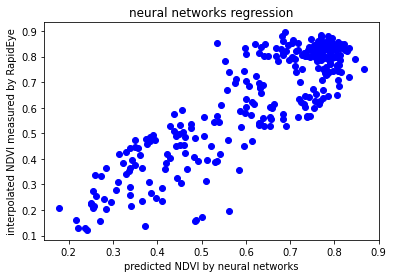

Fold #2
Fold rmse: 0.112
Fold mean absolute error: 0.082
Fold r2: 0.584
Fold correlation coefficient: 0.765


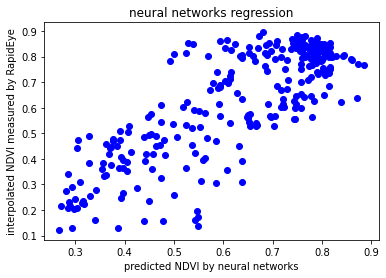

Fold #3
Fold rmse: 0.115
Fold mean absolute error: 0.098
Fold r2: 0.765
Fold correlation coefficient: 0.880


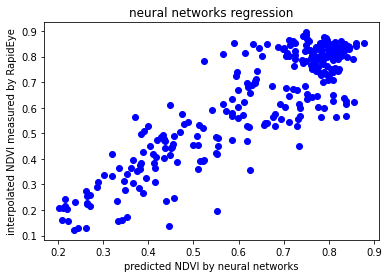

Fold #4
Fold rmse: 0.111
Fold mean absolute error: 0.087
Fold r2: 0.738
Fold correlation coefficient: 0.860


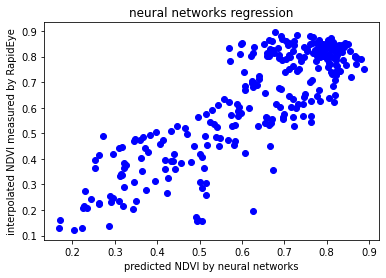

Fold #5
Fold rmse: 0.125
Fold mean absolute error: 0.101
Fold r2: 0.638
Fold correlation coefficient: 0.802


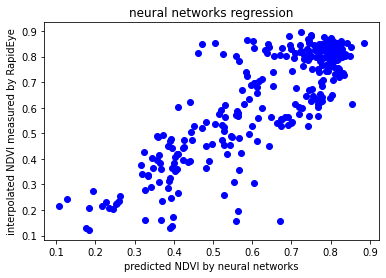

Fold #6
Fold rmse: 0.120
Fold mean absolute error: 0.085
Fold r2: 0.726
Fold correlation coefficient: 0.855


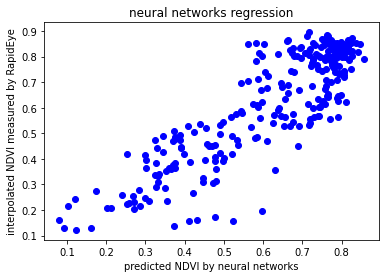

Fold #7
Fold rmse: 0.118
Fold mean absolute error: 0.100
Fold r2: 0.588
Fold correlation coefficient: 0.770


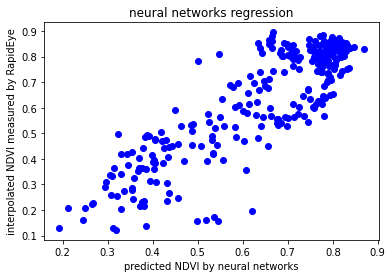

Fold #8
Fold rmse: 0.104
Fold mean absolute error: 0.087
Fold r2: 0.739
Fold correlation coefficient: 0.865


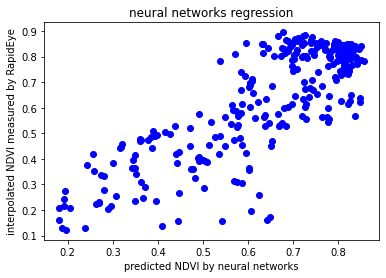

Fold #9
Fold rmse: 0.135
Fold mean absolute error: 0.095
Fold r2: 0.558
Fold correlation coefficient: 0.769


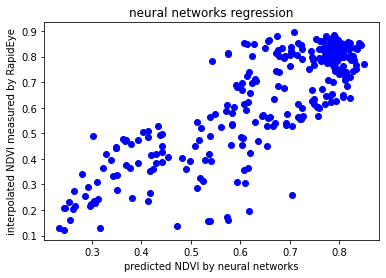

Fold #10
Fold rmse: 0.106
Fold mean absolute error: 0.078
Fold r2: 0.765
Fold correlation coefficient: 0.886


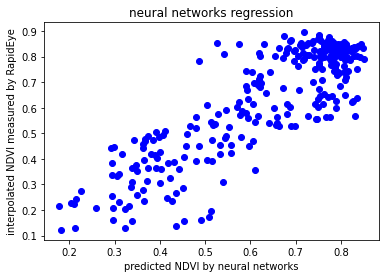


 
Best fold number: 8
Best model rmse: 0.104
Best model mae: 0.087
Best model r2: 0.739
Best model cc: 0.865


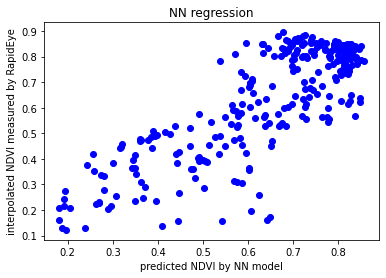

train size:
(261, 1)
test size:
(29, 1)




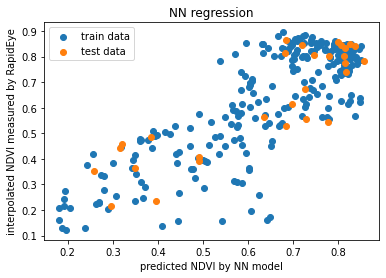


 
Final, out of sample rmse: 0.116
Final, out of sample mae: 0.090
Final, out of sample r2: 0.701
Final, out of sample cc: 0.838


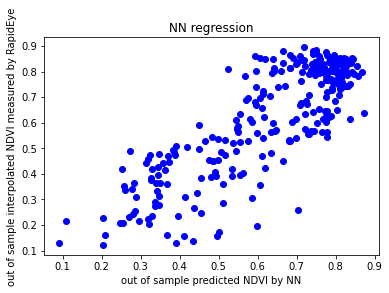

***** Random Forests *****
Fold #1
Fold rmse: 0.116
Fold mean absolute error: 0.086
Fold r2: 0.720
Fold correlation coefficient: 0.852


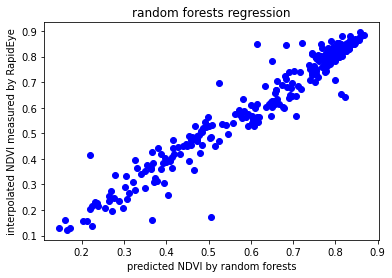

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Fold #2
Fold rmse: 0.087
Fold mean absolute error: 0.070
Fold r2: 0.746
Fold correlation coefficient: 0.869


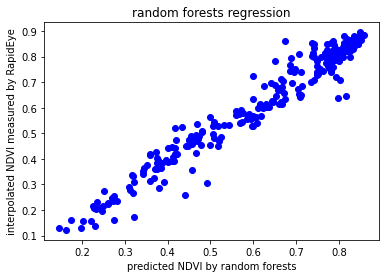

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Fold #3
Fold rmse: 0.093
Fold mean absolute error: 0.078
Fold r2: 0.845
Fold correlation coefficient: 0.933


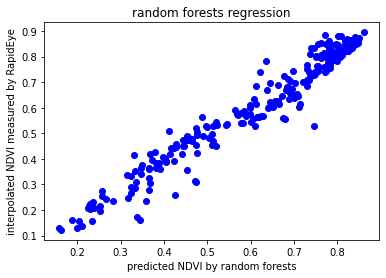

Fold #4
Fold rmse: 0.077
Fold mean absolute error: 0.062
Fold r2: 0.873
Fold correlation coefficient: 0.939


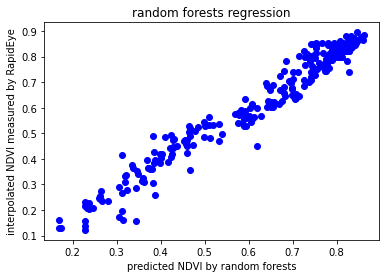

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Fold #5
Fold rmse: 0.128
Fold mean absolute error: 0.083
Fold r2: 0.622
Fold correlation coefficient: 0.790


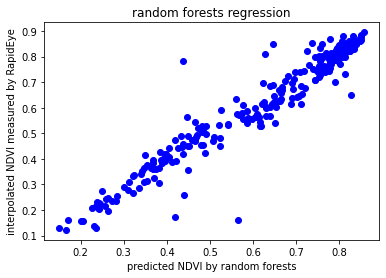

Fold #6
Fold rmse: 0.089
Fold mean absolute error: 0.065
Fold r2: 0.849
Fold correlation coefficient: 0.923


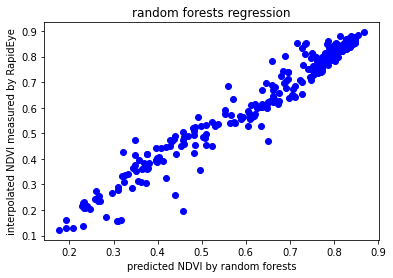

Fold #7
Fold rmse: 0.111
Fold mean absolute error: 0.084
Fold r2: 0.636
Fold correlation coefficient: 0.837


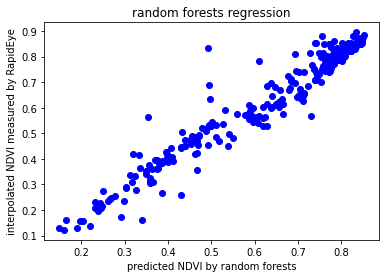

Fold #8
Fold rmse: 0.080
Fold mean absolute error: 0.062
Fold r2: 0.846
Fold correlation coefficient: 0.921


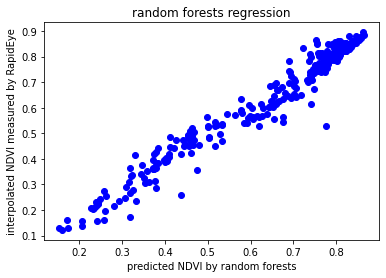

Fold #9
Fold rmse: 0.134
Fold mean absolute error: 0.085
Fold r2: 0.564
Fold correlation coefficient: 0.774


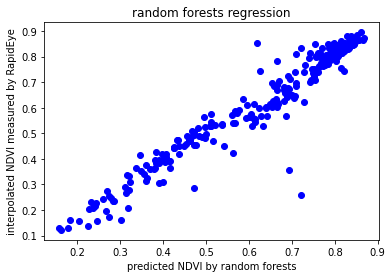

Fold #10
Fold rmse: 0.082
Fold mean absolute error: 0.065
Fold r2: 0.858
Fold correlation coefficient: 0.935


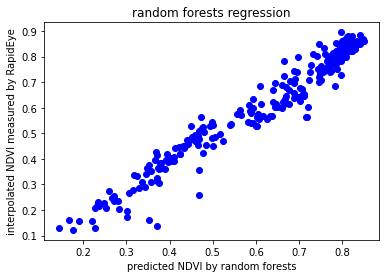


 
Best fold number: 4
Best model rmse: 0.077
Best model mae: 0.062
Best model r2: 0.873
Best model cc: 0.939


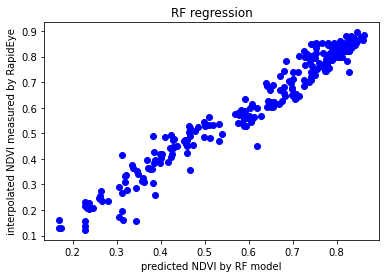

train size:
(261, 1)
test size:
(29, 1)




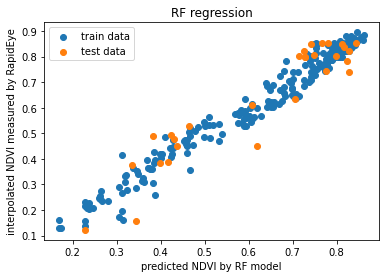

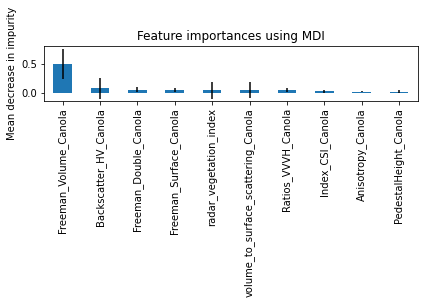

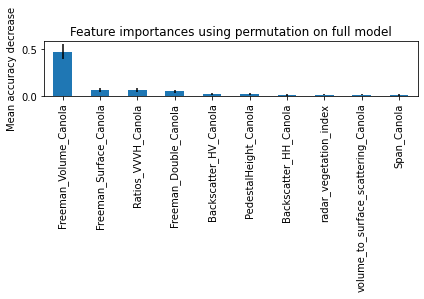


 
Final, out of sample rmse: 0.102
Final, out of sample mae: 0.074
Final, out of sample r2: 0.770
Final, out of sample cc: 0.878


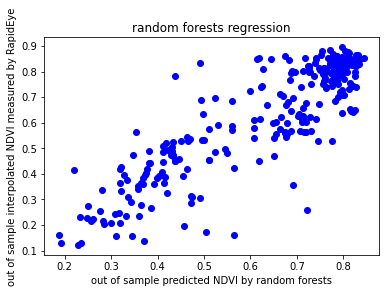

In [ ]:
repetition_number = 1
for repetition in range(repetition_number):


  ##------------------------------------------------------------------------------
  """
  There are three kinds of NDVIs:
  NDVI: measured by RapiEye observation
  NDVI_int: interpolated NDVI for RS2 acquisition times based on available NDVI values
    Here, interpolation is done by averaging the two nearest NDVI values to
    RS2 observations based on the acquisition times.
  NDVI_predicted: predicted NDVI values obtained from SAR data
  """

  dataset_2012, dataset_2016, dataset_2019  = import_data()

  ## Vectorize data
  ## generate separated input and output dataframe;
  ## normalize data if normalization is set to 1
  ## normalization methods: 'min_max', 'mean_std'
  input_yearly, output_yearly, input_with_invalid_NDVIs_yearly, \
    output_with_invalid_NDVIs_yearly, samples = \
    input_output_preparation(dataset_2012, dataset_2016, dataset_2019, \
                              scaling=1, scaling_method='min_max')


  ##------------------------------------------------------------------------------
  ## combine all dataset of various years together
  ##------------------------------------------------------------------------------
  # input_2012.reset_index(drop=True, inplace=True)
  # input_2016.reset_index(drop=True, inplace=True)
  # input_2019.reset_index(drop=True, inplace=True)
  years = [2012, 2016, 2019]
  input_years = [input_yearly[str(years[0])], input_yearly[str(years[1])], \
                 input_yearly[str(years[2])]]
  output_years = [output_yearly[str(years[0])], output_yearly[str(years[1])], \
                 output_yearly[str(years[2])]]

  inputs = pd.concat(input_years, axis=0, ignore_index=True)
  outputs = pd.concat(output_years, axis=0, ignore_index=True)
  print(f"sample size: {np.size(outputs)}")
  print('input features:')
  print(inputs.keys())

  input_with_invalid_NDVIs_years = \
    [input_with_invalid_NDVIs_yearly[str(years[0])], \
     input_with_invalid_NDVIs_yearly[str(years[1])], \
     input_with_invalid_NDVIs_yearly[str(years[2])]]
  input_vectored_with_invalid_NDVIs = \
    pd.concat(input_with_invalid_NDVIs_years, axis=0, ignore_index=True)
  output_with_invalid_NDVIs_years = \
    [output_with_invalid_NDVIs_yearly[str(years[0])], \
     output_with_invalid_NDVIs_yearly[str(years[1])], \
     output_with_invalid_NDVIs_yearly[str(years[2])]]
  output_vectored_with_invalid_NDVIs = \
    pd.concat(output_with_invalid_NDVIs_years, axis=0, ignore_index=True)


  ##------------------------------------------------------------------------------
  ## correlation coefficient between RS2 SAR parameters and RapidEye NDVI
  ##------------------------------------------------------------------------------
  corre_coefs = []
  for field in inputs.keys():
    corre_coef = np.corrcoef(np.transpose(inputs[field]).astype(float), \
            np.transpose(outputs.values).astype(float))
    corre_coefs.append([field, corre_coef[0, 1]])
  print('correlation coefiicient between RS2 SAR parameters and RapidEye NDVI: ')
  print(corre_coefs)

  ##------------------------------------------------------------------------------
  ## feature selection: select predictor variables
  ##------------------------------------------------------------------------------
  ## model_name = 'Lasso' or 'Ridge'
  ## here, Lasso works well with alpha=0.1
  # selected_inputs = predictor_selection(inputs, outputs, alpha=0.05, \
  #   selection_criteria=1, model_name='lasso') # alpha=0.02
  selected_inputs, selected_input_vectored_with_invalid_NDVIs, selected_columns = \
    predictor_selection(inputs, outputs, \
      input_vectored_with_invalid_NDVIs, alpha=10, \
      selection_criteria=10, model_name='lasso') # alpha=0.02, 0.05, 0.001, selection_criteria=0.01
  # selected_inputs = inputs.copy()

  outputs_normalized = outputs/100
  # inputs_normalized = inputs.copy()
  inputs_normalized = selected_inputs.copy()

  # print(np.corrcoef(inputs['Entropy_Canola'], inputs['Freeman_Volume_Canola']))
  # plt.scatter(inputs['Entropy_Canola'], inputs['Freeman_Volume_Canola'], color="blue")
  # plt.xlabel('Entropy_Canola')
  # plt.ylabel('Freeman_Volume_Canola')
  # plt.show()




  # ## plot interpolated NDVI vs selected predictor variables
  # for key in selected_inputs.keys():
  #   plt.scatter(selected_inputs[key], outputs_normalized, color="blue")
  #   # plt.scatter(x_test[:, i], y_test, color="red", label='test')
  #   plt.xlabel(key)
  #   plt.ylabel("NDVI_interpolated")
  #   # plt.legend()
  #   plt.show()

  ##----------------------------------------------------------------------------
  ## predict NDVI with regression models
  ##----------------------------------------------------------------------------

  ##----------------------------------------------------------------------------
  ## neural network multi-layer Perceptron (NN-MLP) regressor

  """
  based on sklearn documentation on https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

  activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
  Activation function for the hidden layer.
  ‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
  ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
  ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
  ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

  solver: {‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
  The solver for weight optimization.
  ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
  ‘sgd’ refers to stochastic gradient descent.
  ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
  Note: The default solver ‘adam’ works pretty well on relatively
  large datasets (with thousands of training samples or more) in terms of
  both training time and validation score. For small datasets, however,
  ‘lbfgs’ can converge faster and perform better.

  alpha: float, default=0.0001
  L2 penalty (regularization term) parameter.

  batch_size: int, default=’auto’
  Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’,
  the classifier will not use minibatch.
  When set to “auto”, batch_size=min(200, n_samples)
  """

  print('***** Neural Network *****')
  # ## k_fold = 10 gives the best results among 10, 20, and 30 in MLP regression
  # # output_predict_mlp = \
  # #   mlp_regression(inputs_normalized, outputs_normalized, activation='identity', \
  # #                   solver='lbfgs', alpha=0.0001, batch_size=200, max_iter=1000, k_fold=10)
  output_predict_mlp, model_mlp = \
    mlp_regression(inputs_normalized, outputs_normalized, \
                   selected_input_vectored_with_invalid_NDVIs, \
                   activation='relu', solver='adam', alpha=0.0001, \
                   batch_size=200, max_iter=500, k_fold=10)

  # ## remove invalid data with negative values of NDVI
  # Y_test = y_test.copy() # to make sure that the main y_test and y_train dataframes are not changed
  # Y_train = y_train.copy()
  # y_test_predict_mlp, y_test_mlp, y_train_predict_mlp, y_train_mlp = \
  #   remove_invalid_predicted_values(y_test_predict_mlp, \
  #   Y_test, y_train_predict_mlp, Y_train)

  # ## plot NDVI test data vs NDVI predicted data
  # plt.scatter(output_predict_mlp, outputs_normalized, color="blue")
  # plt.xlabel("predicted NDVI by MLP")
  # plt.ylabel("interpolated NDVI measured by RapidEye")
  # plt.title("MLP regression")
  # plt.show()


  ##----------------------------------------------------------------------------
  ## Random forests regression
  print('***** Random Forests *****')
  ## k_fold =  gives the best results among 10, 20, and 30 in RF regression
  # output_predict_rf = random_forest_regression(inputs_normalized, outputs_normalized, k_fold=10)
  output_predict_rf, model_rf = random_forest_regression(inputs_normalized, \
      outputs_normalized, selected_input_vectored_with_invalid_NDVIs, k_fold=10)

  # ## plot NDVI measured by RapidEye vs NDVI predicted
  # plt.scatter(output_predict_rf, outputs_normalized, color="blue")
  # plt.xlabel("predicted NDVI by random forest")
  # plt.ylabel("interpolated NDVI measured by RapidEye")
  # plt.title("random forest regression")
  # plt.show()


  ##----------------------------------------------------------------------------
  ## export the predicted results of the available days on Drive
  years = [2012, 2016, 2019]
  i = 0
  previous_n_samples = 0
  output_with_invalid_NDVIs = output_vectored_with_invalid_NDVIs.values.tolist()
  for year in years:

    n_fields = samples[str(years[i])][0]
    n_days = samples[str(years[i])][1]
    n_samples = samples[str(years[i])][2] + previous_n_samples
    i = i + 1

    output_predict_mlp_year = output_predict_mlp[previous_n_samples:(n_samples)]
    output_predict_rf_year = output_predict_rf[previous_n_samples:(n_samples)]
    output_vectored_with_invalid_NDVIs_year = output_with_invalid_NDVIs[previous_n_samples:(n_samples)]
    previous_n_samples = n_samples

    NDVI_predicted_mlp_sorted = np.reshape(output_predict_mlp_year, (n_fields, n_days))
    NDVI_predicted_mlp_sorted_dict = {"NDVI_pred_mlp": NDVI_predicted_mlp_sorted, "label": "MLP"}
    NDVI_predicted_rf_sorted = np.reshape(output_predict_rf_year, (n_fields, n_days))
    NDVI_predicted_rf_sorted_dict = {"NDVI_pred_rf": NDVI_predicted_rf_sorted, "label": "RF"}
    NDVI_S2_sorted = np.reshape(output_vectored_with_invalid_NDVIs_year, \
                                (n_fields, n_days))

    from scipy.io import savemat
    # drive.mount('/content/drive')
    filename_pred_mlp = "/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/NDVI_predicted_mlp_" + str(year) + ".mat"
    filename_pred_rf = "/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/NDVI_predicted_rf_" + str(year) + ".mat"
    savemat(filename_pred_mlp, NDVI_predicted_mlp_sorted_dict)
    savemat(filename_pred_rf, NDVI_predicted_rf_sorted_dict)
    # savemat("/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/NDVI_predicted_mlp_norm.mat", NDVI_predicted_mlp_sorted_dict)
    # savemat("/content/drive/My Drive/Colab Notebooks/AAFC/RS2_RapidEye_NDVI/NDVI_predicted_rf_norm.mat", NDVI_predicted_rf_sorted_dict)





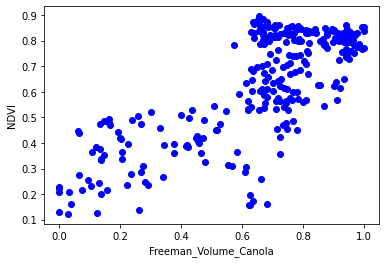

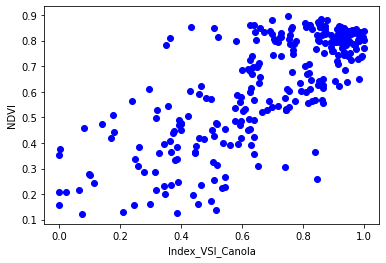

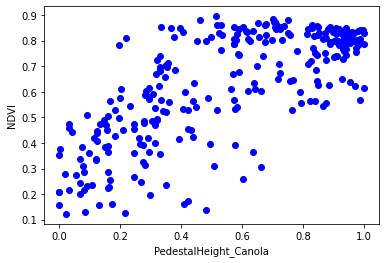

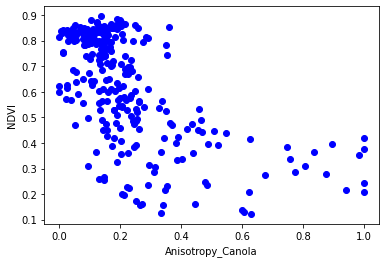

In [ ]:
plt.scatter(inputs['Freeman_Volume_Canola'], outputs/100, color="blue")
plt.xlabel('Freeman_Volume_Canola')
plt.ylabel('NDVI')
plt.show()

plt.scatter(inputs['Index_VSI_Canola'], outputs/100, color="blue")
plt.xlabel('Index_VSI_Canola')
plt.ylabel('NDVI')
plt.show()

plt.scatter(inputs['PedestalHeight_Canola'], outputs/100, color="blue")
plt.xlabel('PedestalHeight_Canola')
plt.ylabel('NDVI')
plt.show()

plt.scatter(inputs['Anisotropy_Canola'], outputs/100, color="blue")
plt.xlabel('Anisotropy_Canola')
plt.ylabel('NDVI')
plt.show()

# print(np.corrcoef(inputs['Index_VSI_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
# plt.scatter(inputs['Index_VSI_Canola'], inputs['Freeman_Volume_Canola'], color="blue")
# plt.xlabel('Index_VSI_Canola')
# plt.ylabel('Freeman_Volume_Canola')
# plt.show()
# print(np.corrcoef(inputs['PedestalHeight_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
# plt.scatter(inputs['PedestalHeight_Canola'], inputs['Freeman_Volume_Canola'], color="blue")
# plt.xlabel('PedestalHeight_Canola')
# plt.ylabel('Freeman_Volume_Canola')
# plt.show()


In [ ]:
# Alpha, Entropy, Index_RFDI, volume_to_surface_scattering, radar_vegetation_index
print('alpha')
print(np.corrcoef(inputs['Alpha_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
print(np.corrcoef(inputs['Alpha_Canola'], inputs['Index_VSI_Canola'])[0,1])
print(np.corrcoef(inputs['Alpha_Canola'], inputs['PedestalHeight_Canola'])[0,1])
print('entropy')
print(np.corrcoef(inputs['Entropy_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
print(np.corrcoef(inputs['Entropy_Canola'], inputs['Index_VSI_Canola'])[0,1])
print(np.corrcoef(inputs['Entropy_Canola'], inputs['PedestalHeight_Canola'])[0,1])
print('RFDI')
print(np.corrcoef(inputs['Index_RFDI_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
print(np.corrcoef(inputs['Index_RFDI_Canola'], inputs['Index_VSI_Canola'])[0,1])
print(np.corrcoef(inputs['Index_RFDI_Canola'], inputs['PedestalHeight_Canola'])[0,1])
print('volume_to_surface_scattering')
print(np.corrcoef(inputs['volume_to_surface_scattering_Canola'], inputs['Freeman_Volume_Canola'])[0,1])
print(np.corrcoef(inputs['volume_to_surface_scattering_Canola'], inputs['Index_VSI_Canola'])[0,1])
print(np.corrcoef(inputs['volume_to_surface_scattering_Canola'], inputs['PedestalHeight_Canola'])[0,1])
print('radar_vegetation_index')
print(np.corrcoef(inputs['radar_vegetation_index'], inputs['Freeman_Volume_Canola'])[0,1])
print(np.corrcoef(inputs['radar_vegetation_index'], inputs['Index_VSI_Canola'])[0,1])
print(np.corrcoef(inputs['radar_vegetation_index'], inputs['PedestalHeight_Canola'])[0,1])

alpha
0.8320238877202556
0.9696029370484371
0.9768742644152864
entropy
0.8334605775697674
0.973282310647932
0.9413532622158045
RFDI
-0.8352962068074192
-0.9920018588320735
-0.9357402484431971
volume_to_surface_scattering
0.8320876434396418
0.9686451095031866
0.9734477285293418
radar_vegetation_index
0.8383326358106074
0.9712910247825223
0.9808409490198404
